In [2]:
import cv2
import sys
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_dir = '/mnt/disks/user/project/Dataset/'

#data structure
#final_dir is the final structure as suggested in the thesis

final_dir = [os.path.join(base_dir,'FaceSwap/'),
             os.path.join(base_dir,'Reenactment/'),
             os.path.join(base_dir,'original/')]
print(final_dir)

['/mnt/disks/user/project/Dataset/FaceSwap/', '/mnt/disks/user/project/Dataset/Reenactment/', '/mnt/disks/user/project/Dataset/original/']


In [3]:
videos = pd.DataFrame(columns=['vid_path','fps','frame_count',
                               'duration','height','width',
                               'format','faces','gender',
                               'age','manipulation_type'])

In [4]:
def append_dataframe(videopath):
    fps,frame_count,duration,height,width,face = 0,0,0,0,0,0
    vid_format,gender, manipulation_type = '','',''
    vidObj = cv2.VideoCapture(videopath)
    fps = vidObj.get(cv2.CAP_PROP_FPS)     # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
    frame_count = int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT))
    if (fps != 0) or (frame_count != 0):
        duration = frame_count/fps
    else:
        duration = 0
    height = vidObj.get(cv2.CAP_PROP_FRAME_HEIGHT) 
    width = vidObj.get(cv2.CAP_PROP_FRAME_WIDTH)
    vid_format = videopath.split('.')[1]
    manipulation = videopath.split('/')[-3]
    face,age_val,gender = object_detection(vidObj)
    global videos
    videos = videos.append({'vid_path' : videopath,
                            'fps' : fps,
                            'frame_count': frame_count,
                            'duration': duration,
                            'height': height,
                            'width': width,
                            'format':vid_format,
                            'faces':face,
                            'gender': gender,
                            'age': age_val,
                            'manipulation_type': manipulation
                           }, ignore_index = True) 

In [5]:
def object_detection(vidObj):
    #load models
    age_net = cv2.dnn.readNetFromCaffe('/mnt/disks/user/project/deploy_age.prototxt', '/mnt/disks/user/project/age_net.caffemodel')
    gender_net = cv2.dnn.readNetFromCaffe('/mnt/disks/user/project/deploy_gender.prototxt', '/mnt/disks/user/project/gender_net.caffemodel')
    
    #relevant lists
    age_list = ['(0, 2)', '(4, 6)', '(8, 12)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
    gender_list = ['Male', 'Female']
    MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
    gender = 'None'
    age = (0,0)
    total_faces = 0
    try:
        #Get Faces
        ret, image = vidObj.read() 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.3,
            minNeighbors=3,
            minSize=(30, 30)
        )
        total_faces = len(faces)
        for (x, y, w, h )in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 0), 2)
            #Get Face 
            face_img = image[y:y+h, h:h+w].copy()
            blob = cv2.dnn.blobFromImage(face_img, 1, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

            #Predict Age
            age_net.setInput(blob)
            age_preds = age_net.forward()
            age = age_list[age_preds[0].argmax()]

            #Predict Gender
            gender_net.setInput(blob)
            gender_preds = gender_net.forward()
            gender = gender_list[gender_preds[0].argmax()]
    except Exception: pass
        
    return total_faces, age, gender

In [6]:
#Trial
video_path = '/mnt/disks/user/project/Dataset/FaceSwap/videos/001_870_Deepfakes_c23.mp4'
vidObj = cv2.VideoCapture(video_path)
face,age,gender = object_detection(vidObj)
print('Face '+str(face))
print('Age '+ str(age))
print('Gender '+gender)

Face 1
Age (25, 32)
Gender Male


In [54]:
for video in final_dir:
    path = os.path.join(video+'videos/*.mp4')
    files = glob.glob(path, recursive = True) 
    for file in files:
        append_dataframe(file)
    print('Dataframe ready')

KeyboardInterrupt: 

In [ ]:
len(videos)

In [9]:
videos.to_csv('Video_Dataset.csv')

## Data Cleaning
1. Deleting Videos with 0 duration returned
2. Deleting Videos with No faces found

In [3]:
videos = pd.read_csv('Video_Dataset.csv')

In [12]:
print(videos.loc[videos.duration>50].vid_path)

15      /mnt/disks/user/project/Dataset/FaceSwap/video...
89      /mnt/disks/user/project/Dataset/FaceSwap/video...
117     /mnt/disks/user/project/Dataset/FaceSwap/video...
127     /mnt/disks/user/project/Dataset/FaceSwap/video...
129     /mnt/disks/user/project/Dataset/FaceSwap/video...
136     /mnt/disks/user/project/Dataset/FaceSwap/video...
138     /mnt/disks/user/project/Dataset/FaceSwap/video...
180     /mnt/disks/user/project/Dataset/FaceSwap/video...
190     /mnt/disks/user/project/Dataset/FaceSwap/video...
287     /mnt/disks/user/project/Dataset/FaceSwap/video...
300     /mnt/disks/user/project/Dataset/FaceSwap/video...
305     /mnt/disks/user/project/Dataset/FaceSwap/video...
323     /mnt/disks/user/project/Dataset/FaceSwap/video...
360     /mnt/disks/user/project/Dataset/FaceSwap/video...
364     /mnt/disks/user/project/Dataset/FaceSwap/video...
425     /mnt/disks/user/project/Dataset/FaceSwap/video...
482     /mnt/disks/user/project/Dataset/FaceSwap/video...
503     /mnt/d

In [11]:
videos.dtypes

Unnamed: 0             int64
vid_path              object
fps                  float64
frame_count            int64
duration             float64
height               float64
width                float64
format                object
faces                  int64
gender                object
age                   object
manipulation_type     object
dtype: object

In [13]:
videos.loc[:,['faces','frame_count']] = videos.loc[:,['faces','frame_count']].astype(int)

In [14]:
videos.frame_count.describe()

count    2982.000000
mean      566.469148
std       271.409651
min        29.000000
25%       358.250000
50%       481.000000
75%       695.000000
max      1814.000000
Name: frame_count, dtype: float64

In [13]:
videos.dtypes

Unnamed: 0             int64
vid_path              object
fps                  float64
frame_count            int64
duration             float64
height               float64
width                float64
format                object
faces                  int64
gender                object
age                   object
manipulation_type     object
dtype: object

In [14]:
videos.head()

,Unnamed: 0,vid_path,fps,frame_count,duration,height,width,format,faces,gender,age,manipulation_type
0,0,/mnt/disks/user/project/Dataset/FaceSwap/video...,25.0,554,22.160000,480.0,656.0,mp4,1,Female,"(4, 6)",FaceSwap
1,1,/mnt/disks/user/project/Dataset/FaceSwap/video...,24.0,1198,49.916667,1080.0,1920.0,mp4,2,Female,"(48, 53)",FaceSwap
2,2,/mnt/disks/user/project/Dataset/FaceSwap/video...,25.0,505,20.200000,480.0,600.0,mp4,1,Male,"(25, 32)",FaceSwap
3,3,/mnt/disks/user/project/Dataset/FaceSwap/video...,24.0,217,9.041667,1080.0,1920.0,mp4,1,Male,"(4, 6)",FaceSwap
4,4,/mnt/disks/user/project/Dataset/FaceSwap/video...,30.0,314,10.466667,720.0,1280.0,mp4,1,Female,"(15, 20)",FaceSwap


In [15]:
floats = videos.select_dtypes('float')
floats.describe()

,fps,duration,height,width
count,2982.000000,2982.000000,2982.000000,2982.000000
mean,26.651241,21.873553,751.346747,1262.424547
std,3.708666,11.567288,260.643695,540.133015
min,15.000000,1.208333,480.000000,256.000000
25%,24.000000,13.360000,480.000000,640.000000
50%,25.000000,17.900000,720.000000,1280.000000
75%,30.000000,27.618750,1080.000000,1920.000000
max,60.000000,72.560000,1080.000000,1920.000000


In [18]:
vals = videos.select_dtypes(['float','int'])
vals = vals[['fps','frame_count','duration']]
vals.describe()

,fps,frame_count,duration
count,2982.000000,2982.000000,2982.000000
mean,26.651241,566.469148,21.873553
std,3.708666,271.409651,11.567288
min,15.000000,29.000000,1.208333
25%,24.000000,358.250000,13.360000
50%,25.000000,481.000000,17.900000
75%,30.000000,695.000000,27.618750
max,60.000000,1814.000000,72.560000


In [16]:
videos.faces.describe()

count    2982.000000
mean        1.192488
std         0.709714
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         7.000000
Name: faces, dtype: float64

In [17]:
videos.isin([0,'None',(0,0)]).sum()

Unnamed: 0             1
vid_path               0
fps                    0
frame_count            0
duration               0
height                 0
width                  0
format                 0
faces                228
gender               228
age                    0
manipulation_type      0
dtype: int64

**NOTE**
1. It appears that same set of videos are returning 0 for fps,frame count, duration, height and width therefore can simply use one of the columns to extract null videos
2. Similarly - when faces are no recognised the gender is certainly not recognised
3. The age of (0,0) appears like is not considered in the count

In [18]:
#selecting rows with 0 values for duration/faces = 0, age = (0,0)
empty_files = videos.loc[(videos['duration'] == 0) | (videos['faces'] == 0)]
len(empty_files)

228

In [31]:
empty = videos.loc[(videos['duration'] == 0) | (videos['faces'] == 0)]
len(empty)

228

In [22]:
empty_files.vid_path.iloc[2]

'/mnt/disks/user/project/Dataset/FaceSwap/videos/07_21__secret_conversation__MKU99DVX_DeepFakeDetection_c23.mp4'

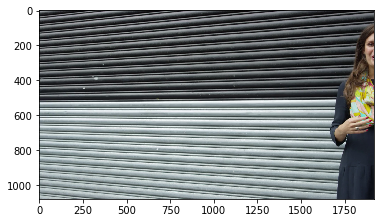

In [35]:
cap = cv2.VideoCapture(empty_files.vid_path.iloc[200])
cap.set(1,2); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

Largely, we are unable to effectively crop/extract faces from the DeepFakeDetection set of videos

**NOTE**

While in 20 instances, the videos appears to exist and has duration values, we would delete the videos. This is because face cropping is one of the important pre-processing steps and these videos would prove to be irrelevant in that case if the face is not recognised

In [36]:
for index, row in empty_files.iterrows():
    os.remove(row.vid_path)
    print(row.vid_path, 'has been removed')

/mnt/disks/user/project/Dataset/FaceSwap/videos/03_04__kitchen_pan__T04P6ELC_DeepFakeDetection_c23.mp4 has been removed
/mnt/disks/user/project/Dataset/FaceSwap/videos/842_714_FaceSwap_c40.mp4 has been removed
/mnt/disks/user/project/Dataset/FaceSwap/videos/07_21__secret_conversation__MKU99DVX_DeepFakeDetection_c23.mp4 has been removed
/mnt/disks/user/project/Dataset/FaceSwap/videos/857_909_FaceSwap_c40.mp4 has been removed
/mnt/disks/user/project/Dataset/FaceSwap/videos/14_01__hugging_happy__0S0NS5C6_DeepFakeDetection_c40.mp4 has been removed
/mnt/disks/user/project/Dataset/FaceSwap/videos/09_01__outside_talking_pan_laughing__SJZRV69J_DeepFakeDetection_c23.mp4 has been removed
/mnt/disks/user/project/Dataset/FaceSwap/videos/11_01__outside_talking_pan_laughing__9OM3VE0Y_DeepFakeDetection_c23.mp4 has been removed
/mnt/disks/user/project/Dataset/FaceSwap/videos/20_09__outside_talking_pan_laughing__O5X0AWR9_DeepFakeDetection_c40.mp4 has been removed
/mnt/disks/user/project/Dataset/FaceSwa

In [37]:
videos.format.value_counts()

mp4    2982
Name: format, dtype: int64

All video files are in mp4 format. The column is practically redundant 

## EDA Analysis
1. Perform Univariate analysis on each feature and returning relevant tables. 
2. Find relationships between variables if any

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

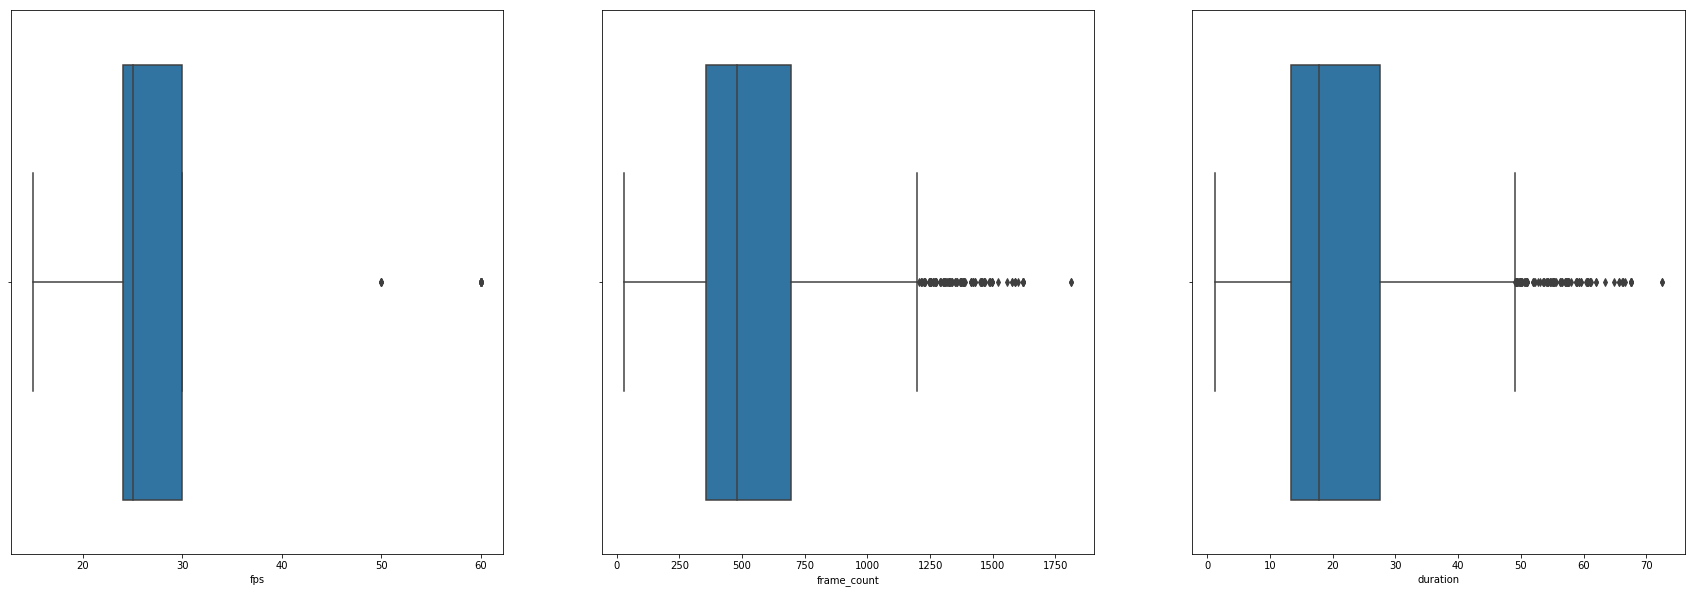

In [30]:
plot = vals
fig, axs = plt.subplots(1,3, figsize=(30,10))
ax_iter = iter(axs.flat)
for i in range(len(vals.columns)):
    ax = next(ax_iter)
    sns.boxplot(x=plot.iloc[:,i], ax=ax)
axs[-1].axis('on')
plt.show()

For all continous variables make a distplot

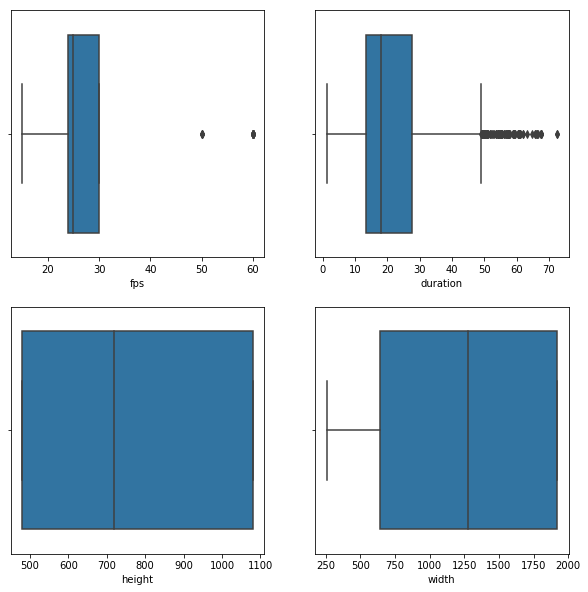

In [39]:
plot = floats
fig, axs = plt.subplots(2,2, figsize=(10,10))
ax_iter = iter(axs.flat)
for i in range(len(floats.columns)):
    ax = next(ax_iter)
    sns.boxplot(x=plot.iloc[:,i], ax=ax)
axs[-1, -1].axis('on')
plt.show()

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


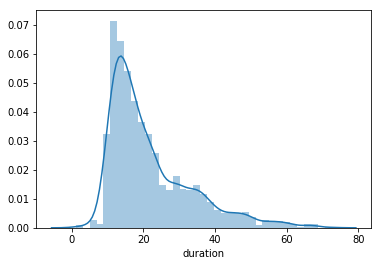

In [40]:
sns.distplot(floats.duration)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


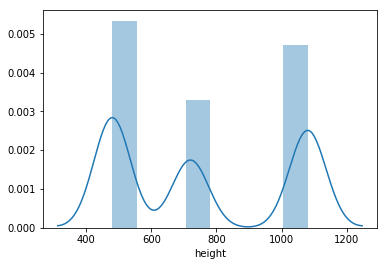

In [32]:
sns.distplot(floats.height)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


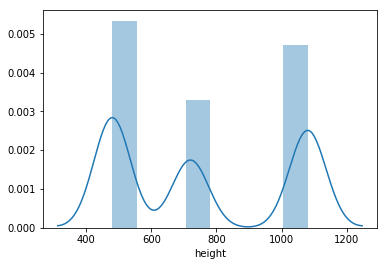

In [31]:
sns.distplot(videos.height)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


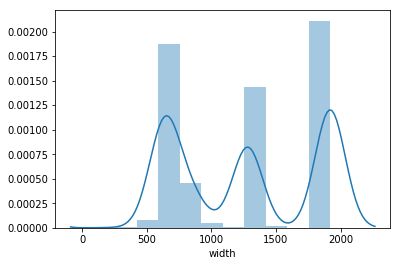

In [42]:
sns.distplot(floats.width)

In [43]:
age_order = ('(0, 2)', '(4, 6)', '(8, 12)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)')

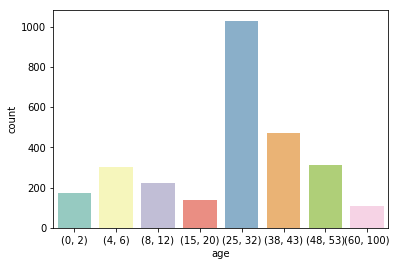

In [44]:
sns.countplot(x = videos.age, palette="Set3", order=age_order)

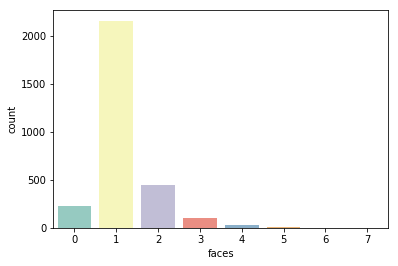

In [45]:
sns.countplot(x = videos.faces, palette="Set3")

For categorical variables using Pie Charts to gauge the distribution

In [46]:
mani_labels = videos.manipulation_type.unique()

In [162]:
mani_values = videos.manipulation_type.value_counts()

In [163]:
manipulation = mani_values.to_dict()
print(manipulation)

{'FaceSwap': 1422, 'original': 1363, 'Reenactment': 600}


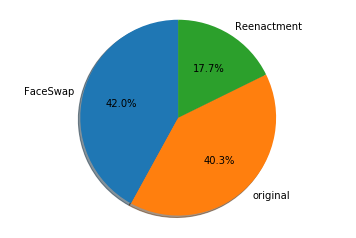

In [165]:
fig1, ax1 = plt.subplots()
ax1.pie(manipulation.values(), labels=manipulation.keys(),autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [156]:
gender_values = videos.gender.value_counts()

In [158]:
gender = gender_values.to_dict()
print(gender)

{'Female': 2142, 'Male': 1015, 'None': 228}


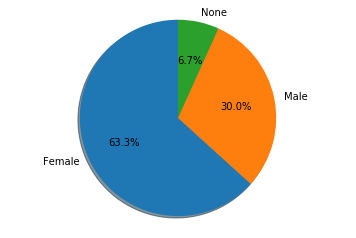

In [160]:
fig1, ax1 = plt.subplots()
ax1.pie(gender.values(), labels=gender.keys(),autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

**Understanding the Face better**

In [55]:
videos.faces.value_counts()

1    2468
2     519
0     228
3     123
4      36
5       5
7       4
6       2
Name: faces, dtype: int64

In [38]:
extra_faces = videos.loc[videos['faces'] > 1]

In [34]:
print(len(extra_faces.vid_path))

595


In [50]:
random_index = random.randint(0, len(extra_faces))
videos_path = extra_faces.iloc[random_index].vid_path

[INFO] Found 2 Faces!


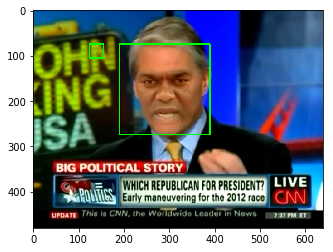

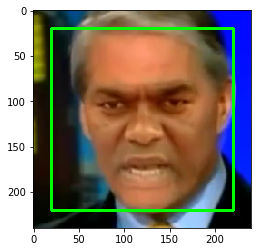

In [51]:
cap = cv2.VideoCapture(videos_path)
cap.set(1,2); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)
print("[INFO] Found {0} Faces!".format(len(faces)))
for (x, y, w, h) in faces:
    #print(faces)
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    roi_color = frame[y-20:y + h + 20, x-20:x + w + 20]
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
import random
from skimage import io
import cv2

In [150]:
rand_index = random.randint(0, len(extra_faces))
video_path = extra_faces.iloc[rand_index].vid_path

[INFO] Found 2 Faces!
Faces,  [[156 101  53  53]
 [458 246 195 195]]
Final Face [[156 101  53  53]
 [458 246 195 195]]
[[156 101  53  53]
 [458 246 195 195]]
[[156 101  53  53]
 [458 246 195 195]]


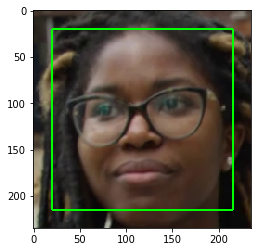

In [151]:
cap = cv2.VideoCapture(video_path)
cap.set(1,2); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)
print("[INFO] Found {0} Faces!".format(len(faces)))
print('Faces, ',str(faces))
#faces = np.delete(faces,1,0)
print('Final Face',str(faces))
for (x, y, w, h) in faces:
    print(faces)
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    roi_color = frame[y-20:y + h + 20, x-20:x + w + 20]
plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))
plt.show()